### Install Dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import imghdr
from matplotlib import pyplot as plt

C:\Users\kimig\AppData\Local\Temp\ipykernel_14004\3597419235.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

### Clean up "dodgy images"

In [4]:
data_dir = 'classification_data'
image_exts = ['jpg', 'jpeg', 'png', 'bmp']

In [5]:
os.listdir(os.path.join(data_dir, 'happy'))[:3]

['05-12-21-happy-people.jpg',
 '10-Habits-of-Happy-People-Seniors-Today.jpg',
 '1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Grab data

In [8]:
data = tf.keras.utils.image_dataset_from_directory('classification_data')
data

Found 160 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### convert dataset into an array of numpy arrays (conversion of images to 256*256)

In [9]:
data_iterator = data.as_numpy_iterator()
data_iterator.next()

(array([[[[ 25.       ,  55.       ,  47.       ],
          [ 26.       ,  56.       ,  48.       ],
          [ 28.       ,  53.       ,  47.       ],
          ...,
          [ 49.       ,  66.       ,  60.       ],
          [ 45.75     ,  64.75     ,  58.75     ],
          [ 45.       ,  64.       ,  58.       ]],
 
         [[ 27.       ,  54.       ,  47.       ],
          [ 28.       ,  55.       ,  48.       ],
          [ 29.       ,  54.       ,  48.       ],
          ...,
          [ 49.       ,  66.       ,  60.       ],
          [ 45.75     ,  64.75     ,  58.75     ],
          [ 45.       ,  64.       ,  58.       ]],
 
         [[ 28.       ,  53.       ,  47.       ],
          [ 28.       ,  53.       ,  47.       ],
          [ 29.       ,  54.       ,  48.       ],
          ...,
          [ 49.       ,  66.       ,  60.       ],
          [ 46.       ,  65.       ,  59.       ],
          [ 45.       ,  64.       ,  58.       ]],
 
         ...,
 
         [[ 

### we can see from above, we have 2 differ arrays: image and labels. 

In [10]:
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

### (32, 256, 256, 3)

### 32 = number of images in this batch
### 256*256 = size of image
### 3 = number of channels in each image (r,g,b)

### Lets look at 4 images in a certain batch

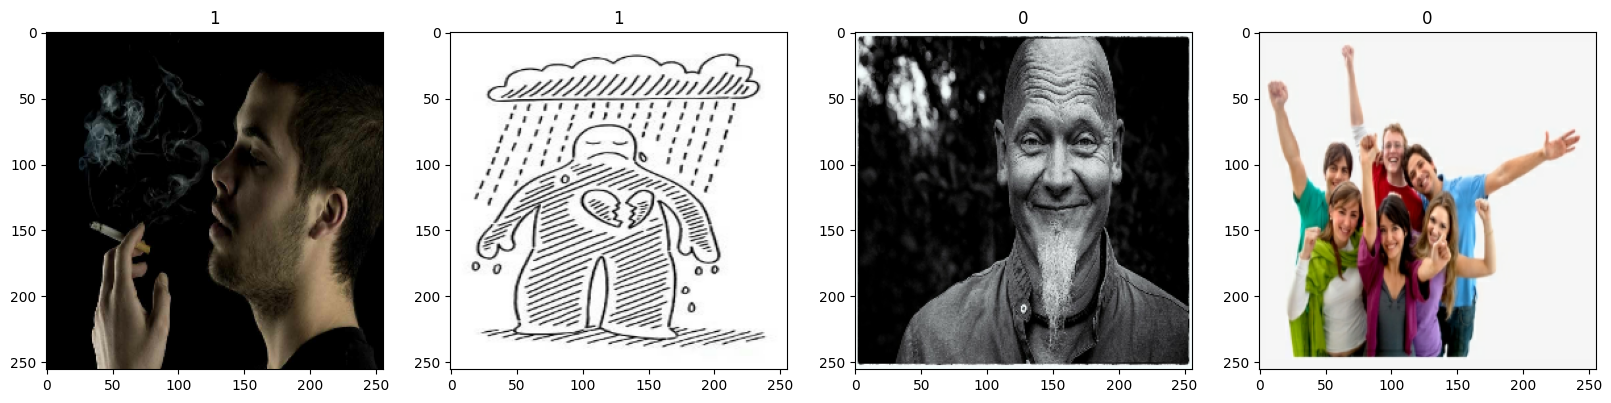

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### This shows us that 0 = happy and 1 = sad

### Scale images

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
data.as_numpy_iterator().next()

(array([[[[0.972549  , 0.972549  , 0.972549  ],
          [0.972549  , 0.972549  , 0.972549  ],
          [0.972549  , 0.972549  , 0.972549  ],
          ...,
          [0.26667732, 0.1686381 , 0.09020673],
          [0.34024623, 0.242207  , 0.16377564],
          [0.33096433, 0.24861139, 0.16625845]],
 
         [[0.972549  , 0.972549  , 0.972549  ],
          [0.972549  , 0.972549  , 0.972549  ],
          [0.972549  , 0.972549  , 0.972549  ],
          ...,
          [0.4149218 , 0.31688255, 0.2384512 ],
          [0.3106899 , 0.21265067, 0.1342193 ],
          [0.32170314, 0.23542863, 0.1530757 ]],
 
         [[0.972549  , 0.972549  , 0.972549  ],
          [0.972549  , 0.972549  , 0.972549  ],
          [0.972549  , 0.972549  , 0.972549  ],
          ...,
          [0.3183146 , 0.2202754 , 0.14184403],
          [0.2903507 , 0.19231148, 0.11388011],
          [0.3132548 , 0.20167392, 0.13001338]],
 
         ...,
 
         [[0.6357727 , 0.62792957, 0.6710668 ],
          [0.64065

### you can see above that the data is scaled and the rgb is the same

In [14]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

### Build Model

In [16]:
# Conv2D(filters, kernel_size, stride, activation, input_shape)
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),     # output -> (254,254,16) (256-3+1) and then we have 16 filters.
    MaxPooling2D(),                                                         # output -> (127,127,16) (254/2).
    
    Conv2D(32, (3,3), 1, activation='relu'),                                # output -> (125,125,32).
    MaxPooling2D(),                                                         # output -> (62,62,32) (maxpooling does floor(125/2)).
    
    Conv2D(16, (3,3), 1, activation='relu'),                                # output -> (60,60,32).
    MaxPooling2D(),                                                         # output -> (30,30,16).
    
    Flatten(),                                                              # output -> 30 * 30 * 16 = (None, 14,400) aka array with 14,400 elements.

    Dense(256, activation='relu'),                                          # 256 neurons on dense layer that applies max(0,x) for each neuron.
    
    Dense(1, activation='sigmoid')                                          # 1 ouptut (sigmoid good for binary classification problems).
])

c:\Users\kimig\OneDrive - The George Washington University\ML\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# adam : good optimizer for cnn (a lot of noisy data + frequently occuring data)
# binary crossentropy: binary problems; how likely the predicted values are from the true values.
# accuracy : metric we are trying to measure on (how well we are classyfing an image as 0 or 1 on).

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [20]:
logdir = 'logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# training on train (letting model learn what is happy and sad)
# validate it at the end with validation data

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.4414 - loss: 1.1652 - val_accuracy: 0.3906 - val_loss: 1.0155
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step - accuracy: 0.4440 - loss: 0.8901 - val_accuracy: 0.8281 - val_loss: 0.6626
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.7552 - loss: 0.6408 - val_accuracy: 0.5625 - val_loss: 0.6421
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - accuracy: 0.6732 - loss: 0.5865 - val_accuracy: 0.5938 - val_loss: 0.5982
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step - accuracy: 0.6732 - loss: 0.5808 - val_accuracy: 0.8594 - val_loss: 0.5960
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.8190 - loss: 0.5916 - val_accuracy: 0.7031 - val_loss: 0.5363
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - accuracy: 0.6380 - loss: 0.5804 - val_accuracy: 0.7969 - val_loss: 0.5065
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 527ms/step - accuracy: 0.8385 - loss: 0.4855 - val_accuracy: 0.8281 - val_loss:

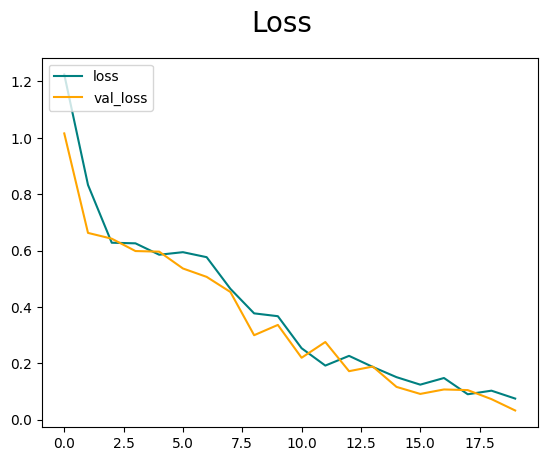

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

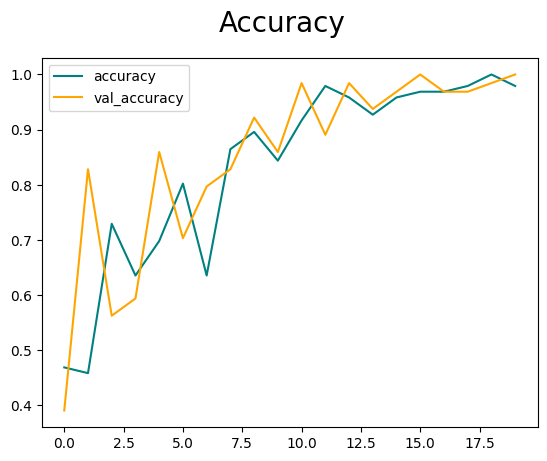

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Test